In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score

# Data Exploration

In [2]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


The tweets have the following categories:
1. not_cyberbullying
2. gender
3. religion
4. age
5. etnicity
6. other_cyberbullying

In [3]:
df.cyberbullying_type.unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

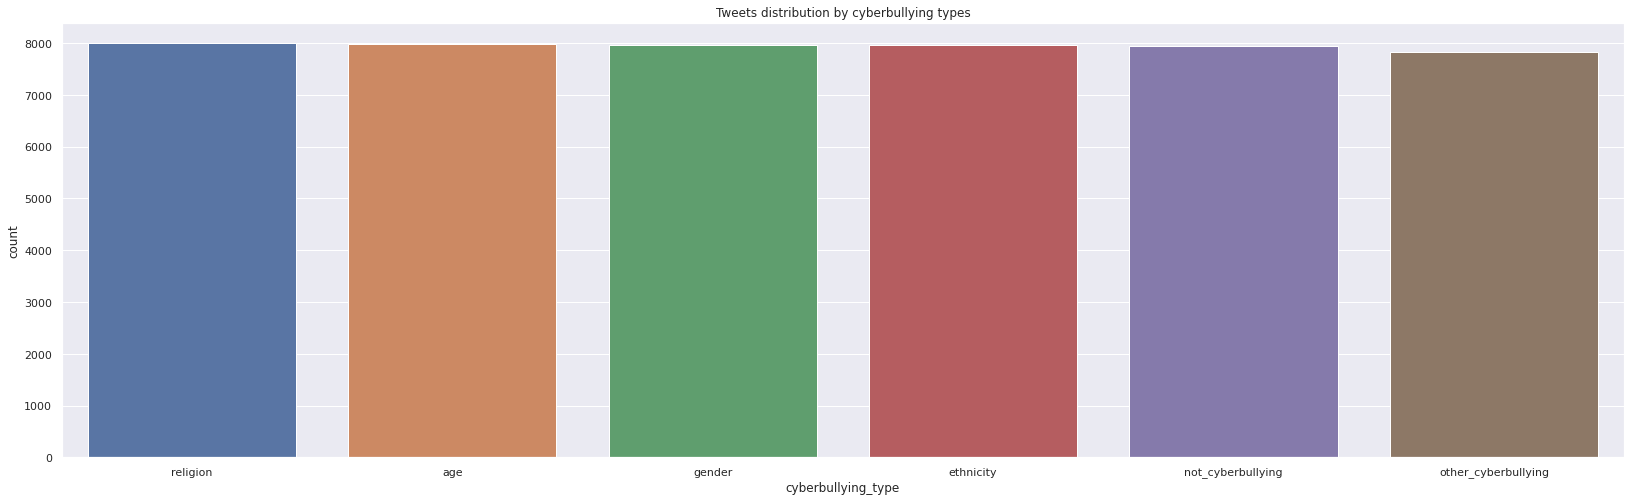

In [4]:
sns.set(rc={'figure.figsize':(28,8)})
sns.countplot(x="cyberbullying_type", data=df, order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [5]:
(df.cyberbullying_type.value_counts(normalize=True) * 100)

religion               16.770108
age                    16.757527
gender                 16.717689
ethnicity              16.692527
not_cyberbullying      16.658978
other_cyberbullying    16.403170
Name: cyberbullying_type, dtype: float64

Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

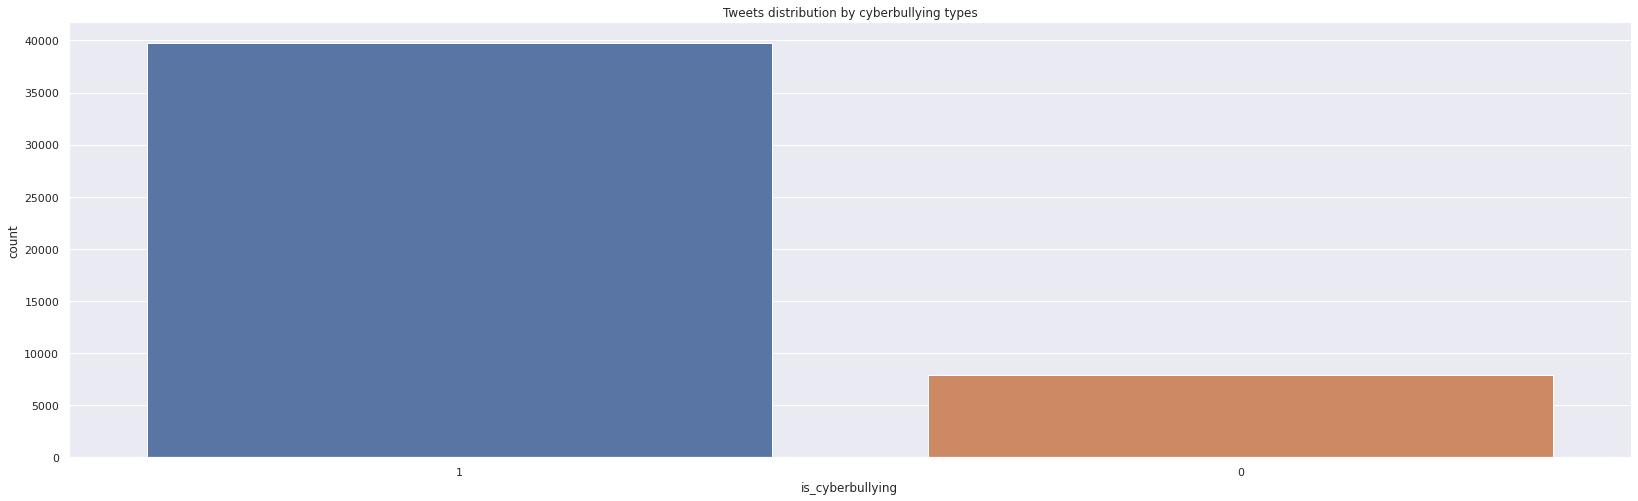

In [6]:
df["is_cyberbullying"] = df.cyberbullying_type != "not_cyberbullying"
df["is_cyberbullying"] = df["is_cyberbullying"].astype(int)
sns.countplot(x="is_cyberbullying", data=df, order=df.is_cyberbullying.value_counts().index).set_title("Tweets distribution by cyberbullying types")

In [7]:
(df.is_cyberbullying.value_counts(normalize=True) * 100)

1    83.341022
0    16.658978
Name: is_cyberbullying, dtype: float64

# Data Preprocessing

Clean text by removing punctuation, numbers and extra spaces, removing stop words, and lemmatization:

In [8]:
import emoji
from nltk.stem import PorterStemmer

def initial_cleaning(text):
    text = re.sub(r"^RT[\s]+","",text)
    text = text.lower()
    text = re.sub(r"https?:\/\/.*[\r\n]*","https",text)
    text = re.sub(r"@[A-Za-z0-9]+","",text)
    text = re.sub(emoji.get_emoji_regexp(),r" ",text)
    text = re.sub(r'[0-9]',' ',text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    return text

def remove_stopword(text):
    a = [i for i in text.split() if i not in stopwords.words('english')]
    return ' '.join(a)

porter = PorterStemmer()
def stem(text):
    a = [porter.stem(i) for i in text.split()]
    return ' '.join(a)

wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
def lemmatizer(text):
    word_pos_tags = nltk.pos_tag(tokenizer.tokenize(text))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

def text_preprocessing(text):
    return lemmatizer(stem(remove_stopword(initial_cleaning(text))))

df["original_tweet"] = df.tweet_text
df.tweet_text = df.tweet_text.apply(lambda x: text_preprocessing(x))
df

,tweet_text,cyberbullying_type,is_cyberbullying,original_tweet
0,word katandandr food crapilici mkr,not_cyberbullying,0,"In other words #katandandre, your food was cra..."
1,aussietv white mkr theblock imacelebrityau tod...,not_cyberbullying,0,Why is #aussietv so white? #MKR #theblock #ImA...
2,classi whore red velvet cupcak,not_cyberbullying,0,@XochitlSuckkks a classy whore? Or more red ve...
3,gio meh p thank head concern anoth angri dude ...,not_cyberbullying,0,"@Jason_Gio meh. :P thanks for the heads up, b..."
4,isi account pretend kurdish account like islam...,not_cyberbullying,0,@RudhoeEnglish This is an ISIS account pretend...
...,...,...,...,...
47687,black ppl expect anyth depend anyth yet free p...,ethnicity,1,"Black ppl aren't expected to do anything, depe..."
47688,turner withhold disappoint turner call court “...,ethnicity,1,Turner did not withhold his disappointment. Tu...
47689,swear god dumb nigger bitch get bleach hair re...,ethnicity,1,I swear to God. This dumb nigger bitch. I have...
47690,yea fuck rt your nigger fuck unfollow fuck dum...,ethnicity,1,Yea fuck you RT @therealexel: IF YOURE A NIGGE...


Convert text into vectors using Word2Vec dictionary:

In [9]:
from gensim.models import Word2Vec

class MeanEmbeddingVectorizer():
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])
    
    def fit(self, X, y):
        return self

df["tokenized"] = [tokenizer.tokenize(i) for i in df['tweet_text']]
model = Word2Vec(df["tokenized"], min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 
modelw = MeanEmbeddingVectorizer(w2v)

In [10]:
df["cyberbullying_type_code"] = df.cyberbullying_type.astype('category').cat.codes
df["cyberbullying_type_code"].unique()

array([3, 2, 5, 4, 0, 1], dtype=int8)

Let's split the data with validating all cyberbullying types are represented in both test and train sets (using **stratify** parameter):

In [11]:
# Split to train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["tokenized"],df["cyberbullying_type_code"],test_size=0.2,shuffle=True, stratify=df["cyberbullying_type"])

# Convert train and test sets to vectors
X_train_vectors_w2v = modelw.transform(X_train)
X_test_vectors_w2v = modelw.transform(X_test)

Let's use XGBoost for this classification, as is a state-of-the-art algorithm in many classification problems. I used GridSearchCV to perform hyparameter tuning.

In [12]:
from xgboost import XGBClassifier

model = XGBClassifier(
    use_label_encoder=False,
    max_depth=4,
    min_child_weight=2,
    gamma=0.3,
    subsample=0.7,
    colsample_bytree=0.6,
    reg_alpha=0.1
)
model.fit(X_train_vectors_w2v, y_train)

[22:29:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.3, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0.1, reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [13]:
predictions = model.predict(X_test_vectors_w2v)
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test, predictions))

Accuracy: 0.7832057867701017
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1598
           1       0.93      0.93      0.93      1592
           2       0.88      0.75      0.81      1595
           3       0.57      0.51      0.54      1589
           4       0.52      0.63      0.57      1565
           5       0.89      0.91      0.90      1600

    accuracy                           0.78      9539
   macro avg       0.79      0.78      0.78      9539
weighted avg       0.79      0.78      0.79      9539



In [14]:
misclassified_indices = np.where(y_test != predictions)
misclassified_data = df.iloc[misclassified_indices]
misclassified_data

,tweet_text,cyberbullying_type,is_cyberbullying,original_tweet,tokenized,cyberbullying_type_code
0,word katandandr food crapilici mkr,not_cyberbullying,0,"In other words #katandandre, your food was cra...","[word, katandandr, food, crapilici, mkr]",3
8,everyth mostli priest,not_cyberbullying,0,@stockputout everything but mostly my priest,"[everyth, mostli, priest]",3
12,ughhh mkr,not_cyberbullying,0,Ughhhh #MKR,"[ughhh, mkr]",3
19,gotta walk class offici hate stupid bu system,not_cyberbullying,0,Now I gotta walk to classss?! I officially hat...,"[gotta, walk, class, offici, hate, stupid, bu,...",3
25,educ nation bulli turn http,not_cyberbullying,0,Education Nation: Bullying | Turn to 10 http:/...,"[educ, nation, bulli, turn, http]",3
...,...,...,...,...,...,...
9522,say joke rape dumb he ’ gay gay men like men,gender,1,Who said my joke is about rape? So dumb. He’s ...,"[say, joke, rape, dumb, he, ’, gay, gay, men, ...",2
9524,mind sure,gender,1,@jiabrahams ...in her mind. Sure.,"[mind, sure]",2
9529,lmao min car dad station he ’ listen tell gay ...,gender,1,Lmao 5 mins in the car with my dad and the sta...,"[lmao, min, car, dad, station, he, ’, listen, ...",2
9531,straight teenag fuckboy use n word joke rape u...,gender,1,"straight teenage fuckboys that use the n word,...","[straight, teenag, fuckboy, use, n, word, joke...",2


Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

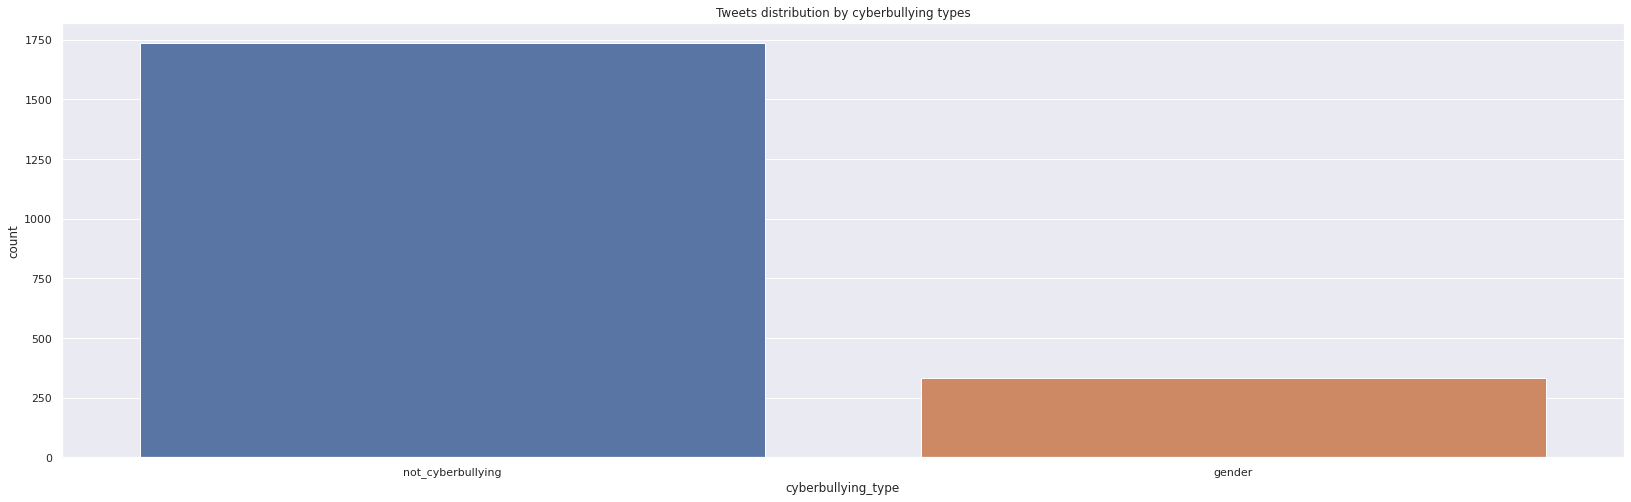

In [15]:
sns.countplot(x="cyberbullying_type", data=misclassified_data, order=misclassified_data.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types")

# Investigating 'other_cyberbullying' sub-categories

I will use a clustering algorithm to group the tweets from 'other_cyberbullying' category to different groups. Since I don't know what is the number of groups I'm looking for K-means would not be a good choice. I decided to use DBSCAN which is a density-based algorithm and can find the required number of clusters.

In [16]:
from sklearn.cluster import DBSCAN

other_cyberbullying_tweets = df[df["cyberbullying_type"] == "other_cyberbullying"]
vectorized = modelw.transform(other_cyberbullying_tweets["tokenized"])

model = DBSCAN(eps=0.8)
model.fit(vectorized)

DBSCAN(eps=0.8)

In [17]:
print(set(model.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}


In [18]:
other_cyberbullying_tweets.loc[other_cyberbullying_tweets["topic"] == 3]

KeyError: 'topic'

In [ ]:
other_cyberbullying_tweets["topic"] = model.labels_
other_cyberbullying_tweets

In [ ]:
df[df.cyberbullying_type_code == 4]